## Project Description
Investigate user behavior for a food company's app.
1. Study the sales funnel. Find out how users reach the purchase stage. How many users actually make it to this stage? How many get stuck at previous stages? Which stages in particular?
2. Look at the results of an A/A/B test to decide wether to change the fonts for the entire app.

The users are split into three groups: two control groups get the old fonts and one test group gets the new ones. 
#### The goal: 
Find out which set of fonts produces better results.
Creating two A groups has certain advantages. We can make it a principle that we will only be confident in the accuracy of our testing when the two control groups are similar. If there are significant differences between the A groups, this can help us uncover factors that may be distorting the results. Comparing control groups also tells us how much time and data we'll need when running further tests.

### Table of Contents

* [1. Open the data file and read the general information](#chapter1)
* [2. Prepare the data for analysis](#chapter2)
* [3. Study and check the data](#chapter3)
* [4. Study the event funnel](#chapter4)
* [5. Study the results of the experiment](#chapter5)
* [6. Conclusion](#chapter6)

In [50]:
!pip install plotly --upgrade

  Attempting uninstall: plotly
    Found existing installation: plotly 5.1.0
    Uninstalling plotly-5.1.0:
      Successfully uninstalled plotly-5.1.0


In [3]:
#!pip install -q -U 'plotly==4.9.0'

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats 
import datetime
from datetime import datetime
import plotly.express as px
import math 

## 1. Open the data file and read the general information <a class="anchor" id="chapter1"></a>

In [51]:
df= pd.read_csv('logs_exp_us.csv', sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [52]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [53]:
df.shape

(244126, 4)

## 2. Prepare the data for analysis <a class="anchor" id="chapter2"></a>

In [54]:
#Rename the columns
df.columns = ['event_name', 'user_id', 'event_datetime', 'experiment_id']

In [55]:
#Check for missing values
df.isnull().count()

event_name        244126
user_id           244126
event_datetime    244126
experiment_id     244126
dtype: int64

In [56]:
#Add a date and time column and a separate column for dates
df['event_datetime'] = df['event_datetime'] .apply(lambda x: datetime.fromtimestamp(x))
df['event_date'] = df['event_datetime'].dt.date
df['event_time'] = df['event_datetime'].dt.time
df.head()

,event_name,user_id,event_datetime,experiment_id,event_date,event_time
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248,2019-07-25,14:48:42


In [57]:
#Check for duplicates
df[df.duplicated()].head()

,event_name,user_id,event_datetime,experiment_id,event_date,event_time
453,MainScreenAppear,5613408041324010552,2019-07-30 11:19:44,248,2019-07-30,11:19:44
2350,CartScreenAppear,1694940645335807244,2019-08-01 00:51:39,248,2019-08-01,00:51:39
3573,MainScreenAppear,434103746454591587,2019-08-01 05:59:37,248,2019-08-01,05:59:37
4076,MainScreenAppear,3761373764179762633,2019-08-01 06:47:46,247,2019-08-01,06:47:46
4803,MainScreenAppear,2835328739789306622,2019-08-01 07:44:01,248,2019-08-01,07:44:01


In [58]:
#check where are the duplicates
for i in df[df.duplicated()].columns:
    print(i, ":", df[df.duplicated()][i].nunique())

event_name : 5
user_id : 237
event_datetime : 352
experiment_id : 3
event_date : 8
event_time : 352


In [59]:
df[df.duplicated()]['event_datetime']

453      2019-07-30 11:19:44
2350     2019-08-01 00:51:39
3573     2019-08-01 05:59:37
4076     2019-08-01 06:47:46
4803     2019-08-01 07:44:01
                 ...        
242329   2019-08-07 22:26:44
242332   2019-08-07 22:26:45
242360   2019-08-07 22:27:29
242362   2019-08-07 22:27:29
242635   2019-08-07 22:36:58
Name: event_datetime, Length: 413, dtype: datetime64[ns]

It seems that the duplucates are in all 5 events, in 237 users, 352 dates and in all 3 groups. In adittion, it seems that the problem was in the whole week (30/7 - 7/8). This means that the data us very corrupted.

In [60]:
df.drop_duplicates().head()

,event_name,user_id,event_datetime,experiment_id,event_date,event_time
0,MainScreenAppear,4575588528974610257,2019-07-25 07:43:36,246,2019-07-25,07:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 14:11:42,246,2019-07-25,14:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 14:28:47,248,2019-07-25,14:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 14:48:42,248,2019-07-25,14:48:42


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   event_name      244126 non-null  object        
 1   user_id         244126 non-null  int64         
 2   event_datetime  244126 non-null  datetime64[ns]
 3   experiment_id   244126 non-null  int64         
 4   event_date      244126 non-null  object        
 5   event_time      244126 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


## 3. Study and check the data <a class="anchor" id="chapter3"></a>

#### How many events are in the logs?

In [62]:
df['event_name'].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

In [63]:
print("Number of events in the logs: " + str(len(df['event_name'].unique())) )

Number of events in the logs: 5


There are 5 events: 
1. MainScreenAppear
2. PaymentScreenSuccessful
3. CartScreenAppear
4. OffersScreenAppear
5. Tutorial

#### How many users are in the logs?

In [64]:
df['user_id'].nunique()

7551

There are 7,551 users in the log

#### What's the average number of events per user?

In [65]:
df.groupby(['user_id'])['event_name'].count().reset_index().sort_values(by='event_name', ascending = False)['event_name'].mean()

32.33028737915508

On average, there are 32 event per user

In [66]:
#calculate the number of uniqe events for each user -how many full actions did the user complete
#grouped the data by number of events and all the users did this events
uniqueEvents = df.groupby(['user_id'])['event_name'].nunique().reset_index().groupby(['event_name'])['user_id'].nunique().reset_index()
uniqueEvents.columns = ['event_number', 'unique_users']
uniqueEvents

,event_number,unique_users
0,1,2707
1,2,1021
2,3,317
3,4,3035
4,5,471


From the table above it seems that only 2707 out of 7,551 users completed the 1st event. 
In adittion, less than  half of the users (only 3035 users of the 7,551 users) did a full circle and completed  the 4th event.

#### What period of time does the data cover? Find the maximum and the minimum date.

In [67]:
df['event_datetime'].describe()

<ipython-input-67-46a60f4b1ba5>:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.



count                  244126
unique                 176654
top       2019-08-01 17:40:35
freq                        9
first     2019-07-25 07:43:36
last      2019-08-08 00:15:17
Name: event_datetime, dtype: object

The maximum date is: 2019-08-08 
The Minimum date is : 2019-07-25

The data covers 14 days

#### Plot a histogram by date and time. Can you be sure that you have equally complete data for the entire period? Older events could end up in some users' logs for technical reasons, and this could skew the overall picture. Find the moment at which the data starts to be complete and ignore the earlier section. What period does the data actually represent?

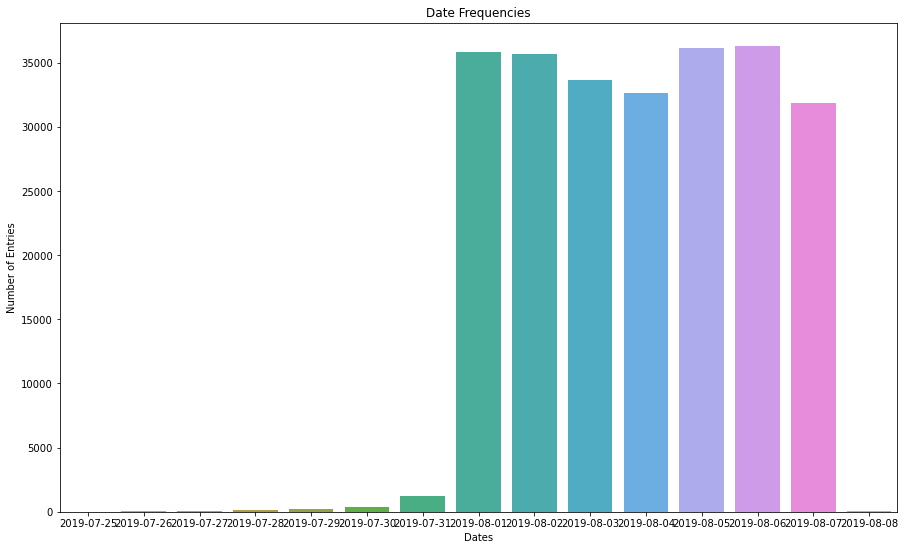

In [68]:
# count the unique dates and their frequencies
events_by_date = df['event_date'].value_counts().rename_axis('event_date').reset_index(name='count').sort_values(by='event_date')

# plot bar graph
plt.figure(figsize=(15, 9))
ax = sns.barplot(data = events_by_date, x='event_date', y='count')

plt.title('Date Frequencies')
plt.xlabel('Dates')
plt.ylabel('Number of Entries')

plt.show()

The period of time that the data covers is from: 2019-07-25 to 2019-08-07. 
From the figure above, it can be seen that there was a peak at August 1st 2019, which can indicate that the complete data started from this date and not for the entire period.

A posible reason could be that the first week was the week of the recrutment and there was some technical issues with the recrut of the server

In [69]:
# remove earlier date entries
new_data = df[df['event_date'] >= pd.to_datetime('2019-08-01')]

#### Did you lose many events and users when excluding the older data?
Make sure you have users from all three experimental groups.

In [70]:
new_data.head()

,event_name,user_id,event_datetime,experiment_id,event_date,event_time
1990,MainScreenAppear,7701922487875823903,2019-08-01 00:00:57,247,2019-08-01,00:00:57
1991,MainScreenAppear,2539077412200498909,2019-08-01 00:01:45,247,2019-08-01,00:01:45
1992,OffersScreenAppear,3286987355161301427,2019-08-01 00:02:21,248,2019-08-01,00:02:21
1993,OffersScreenAppear,3187166762535343300,2019-08-01 00:02:23,247,2019-08-01,00:02:23
1994,MainScreenAppear,1118952406011435924,2019-08-01 00:03:25,248,2019-08-01,00:03:25


In [71]:
lost_users = len(df['user_id'].unique()) - len(new_data['user_id'].unique())
lost_events = len(df['event_datetime'].unique()) - len(new_data['event_datetime'].unique())

print('Lost users:', lost_users, ', Lost events:', lost_events)

Lost users: 13 , Lost events: 1843


In [72]:
lost_users_prec = (len(df['user_id'].unique()) - len(new_data['user_id'].unique())) / len(df['user_id'].unique())
lost_events_prec = (len(df['event_datetime'].unique()) - len(new_data['event_datetime'].unique())) / len(df['event_datetime'].unique())
print('Lost users:', "{:.2%}".format(lost_users_prec), ', Lost events:', "{:.2%}".format(lost_events_prec))

Lost users: 0.17% , Lost events: 1.04%


In [73]:
new_data.groupby('experiment_id')['user_id'].nunique().reset_index()

,experiment_id,user_id
0,246,2484
1,247,2517
2,248,2537


When excluding older data than August 1st 2019, we have lost 23% of the users (17 users) and 1.5% of the events (2610 events).
However, we still have users from all three experimental groups. 

## 4. Study the event funnel <a class="anchor" id="chapter4"></a>

#### See what events are in the logs and their frequency of occurrence. Sort them by frequency.

In [74]:
# group by event name and count their frequency of occurrence
new_data.groupby(['event_name'])['event_name'].count().sort_values(ascending = False)

event_name
MainScreenAppear           117992
OffersScreenAppear          46548
CartScreenAppear            42406
PaymentScreenSuccessful     34146
Tutorial                     1044
Name: event_name, dtype: int64

The most frequent event is the main screen with 117,431 events.
The offers screens has 46,350 evets.
The cart screen has 42,365 events.
The payment screen has 34,113 events.
The tutorial is the less frequent event with 1039 events.

#### Find the number of users who performed each of these actions. Sort the events by the number of users.

In [75]:
#find the overall proportions of all users 
users= (new_data.groupby(['event_name'])['user_id'].nunique().sort_values(ascending = False) / new_data.user_id.nunique()).reset_index()

users.style.format({'user_id': '{:,.1%}'.format})




,event_name,user_id
0,MainScreenAppear,98.5%
1,OffersScreenAppear,61.0%
2,CartScreenAppear,49.6%
3,PaymentScreenSuccessful,47.0%
4,Tutorial,11.2%


98% of all users saw the main screen, 61% of all users made the Offers Screen , 49% the cart screen. 47% the payment screend and only 11% did the tutorial.     

#### Calculate the proportion of users who performed the action at least once

In [76]:
at_least_once = new_data.groupby(['user_id','event_name'])['event_time'].count().reset_index()
at_least_once[at_least_once.event_time>=2].groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False) / new_data.groupby(['event_name'])['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           0.967129
OffersScreenAppear         0.851642
CartScreenAppear           0.873929
PaymentScreenSuccessful    0.839548
Tutorial                   0.102017
Name: user_id, dtype: float64

96% out of useres who made the main screen for the first time, made it once again. This is very high retention rate.
for the offer screen, ouy of 61% users who made it, 85% made it once again.
for the cart screen, ouy of 47% users who made it, 84% made it once again.
The retention rate of the pyment - out of 47% users who made a payment, 83% made it once again.

#### In what order do you think the actions took place. Are all of them part of a single sequence? You don't need to take them into account when calculating the funnel.

The order in which the actions took place is:
Main Screen -> Offer Screen -> Cart Screen -> Payment Successful Screen


not all of the actions are part of a single sequence: for example,  it might be possible to make a purchase without viewing the cart screen or make a purchase without seeing the offer screen . 
In adition you don't have to go over the tutorial.

#### Use the event funnel to find the share of users that proceed from each stage to the next. (For instance, for the sequence of events A → B → C, calculate the ratio of users at stage B to the number of users at stage A and the ratio of users at stage C to the number at stage B.)

In [77]:
new_data_funnel =new_data.query('event_name != "Tutorial"')

In [78]:
#extract users id that made an action
funnel_shift = new_data_funnel.groupby(['event_name'])['user_id'].nunique().reset_index().sort_values(by= 'user_id', ascending = False)
funnel_shift =funnel_shift .query('event_name != "Tutorial"')


#calculate the prcentage change from one funnel to another
funnel_shift['percentage_change'] = funnel_shift['user_id'].pct_change()
funnel_shift

,event_name,user_id,percentage_change
1,MainScreenAppear,7423,NaN
2,OffersScreenAppear,4597,-0.380709
0,CartScreenAppear,3736,-0.187296
3,PaymentScreenSuccessful,3540,-0.052463


In [79]:
funnel_by_groups = []
for i in new_data_funnel.experiment_id.unique():
    group = new_data_funnel[new_data.experiment_id==i].groupby(['event_name', 'experiment_id'])['user_id'].nunique().reset_index() \
    .sort_values(by='user_id', ascending=False)
    display(group)
    funnel_by_groups.append(group)

<ipython-input-79-df5fa3cfa50d>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,event_name,experiment_id,user_id
1,MainScreenAppear,247,2479
2,OffersScreenAppear,247,1524
0,CartScreenAppear,247,1239
3,PaymentScreenSuccessful,247,1158


<ipython-input-79-df5fa3cfa50d>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,event_name,experiment_id,user_id
1,MainScreenAppear,248,2494
2,OffersScreenAppear,248,1531
0,CartScreenAppear,248,1231
3,PaymentScreenSuccessful,248,1182


<ipython-input-79-df5fa3cfa50d>:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,event_name,experiment_id,user_id
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542
0,CartScreenAppear,246,1266
3,PaymentScreenSuccessful,246,1200


In [80]:
#concatenate the data
funnel_by_groups = pd.concat(funnel_by_groups)
funnel_by_groups 

,event_name,experiment_id,user_id
1,MainScreenAppear,247,2479
2,OffersScreenAppear,247,1524
0,CartScreenAppear,247,1239
3,PaymentScreenSuccessful,247,1158
1,MainScreenAppear,248,2494
2,OffersScreenAppear,248,1531
0,CartScreenAppear,248,1231
3,PaymentScreenSuccessful,248,1182
1,MainScreenAppear,246,2450
2,OffersScreenAppear,246,1542


In [81]:
#plot the funnel
fig = px.funnel(funnel_by_groups,x='user_id', y='event_name', color='experiment_id', title= 'Users Funnel')
fig.show()

The groups are more or less splited equally. 

#### At what stage do you lose the most users? 

From the funnel above, it can be seen that the stage we lose most of the users is the from the main screen to the offer screen (38% decrease in users who processed to the offer screen)

#### What share of users make the entire journey from their first event to payment?

As can be seen from the table above, the share of users that make the entire journey from the first event (main screen)to the payment screen is 47%

## 5. Study the results of the experiment <a class="anchor" id="chapter5"></a>


#### How many users are there in each group?

In [82]:
users_in_group = new_data.groupby(['experiment_id'])['user_id'].nunique().reset_index()
users_in_group.columns = ['experiment_id', 'number_of_users']
users_in_group

,experiment_id,number_of_users
0,246,2484
1,247,2517
2,248,2537


In the first test group (246) there are 2484 users
In the second test group (247) there are 2513 users
In the third control group (248) there are 2537 users.

The users ampunt in each group is similar.

#### We have two control groups in the A/A test, where we check our mechanisms and calculations. 
#### See if there is a statistically significant difference between samples 246 and 247.

in order to check if there is a statistically significant difference between samples 246 and 247 we need to check the proportions - the share of users from all users in the test that had an event compared to the other test (conversions)

In [83]:
#calculate the number of users in each group
test_1 = new_data[new_data.experiment_id==246]['user_id'].unique()
test_2 = new_data[new_data.experiment_id==247]['user_id'].unique()
control = new_data[new_data.experiment_id==248]['user_id'].unique()

print("The number of users in group 246 is: ", len(test_1))
print("The number of users in group 247 is: ", len(test_2))
print("The number of users in group 248 is: ", len(control))

The number of users in group 246 is:  2484
The number of users in group 247 is:  2517
The number of users in group 248 is:  2537


In [84]:
#calculate the number of users by event in each test group who preformed an action
pivot = new_data.pivot_table(index = 'event_name', values = 'user_id', columns='experiment_id', aggfunc=lambda x: x.nunique()).reset_index()
pivot

experiment_id,event_name,246,247,248
0,CartScreenAppear,1266,1239,1231
1,MainScreenAppear,2450,2479,2494
2,OffersScreenAppear,1542,1524,1531
3,PaymentScreenSuccessful,1200,1158,1182
4,Tutorial,278,284,281


In [85]:
#z-score test (proportion test)
#compare the 2 groups for each event

def check_hypothesis(group1,group2, event, alpha=0.05):
    #success for each group will be the value of action from pivot table
    successes1=pivot[pivot.event_name==event][group1].iloc[0]
    successes2=pivot[pivot.event_name==event][group2].iloc[0]
    
    #value of trials will be the number of users in the groups
    trials1=new_data[new_data.experiment_id==group1]['user_id'].nunique()
    trials2=new_data[new_data.experiment_id==group2]['user_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    print('alpha level: ', 0.05)

    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", event,'and groups',group1,group2) 

In [86]:
#use this function to iterate over list of events or groups
for i in pivot.event_name.unique():
    check_hypothesis(246,247,i, alpha=0.05)

p-value:  0.2182812140633792
alpha level:  0.05
Fail to Reject H0 for CartScreenAppear and groups 246 247
p-value:  0.6756217702005545
alpha level:  0.05
Fail to Reject H0 for MainScreenAppear and groups 246 247
p-value:  0.26698769175859516
alpha level:  0.05
Fail to Reject H0 for OffersScreenAppear and groups 246 247
p-value:  0.10298394982948822
alpha level:  0.05
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247
p-value:  0.9182790262812368
alpha level:  0.05
Fail to Reject H0 for Tutorial and groups 246 247


We want to test the statistical significance of the difference in conversion between control groups 246 and 247. 

The Null Hypothesis H0: There is no statistically significant difference in conversion between control groups 246 and 247. <br>
The Alternative Hypothesis H1: There is a statistically significant difference in conversion between control groups 246 and 247.


For all the events, the p_value is greater than the alpha level of 0.05 which means that we cannot reject the null hypothesis and we determine that there is no statistically significant difference between the two control groups for each event.


We Can you confirm that the groups were split properly since there isn't significant difference in the results.

#### Do the same thing for the group with altered fonts. Compare the results with those of each of the control groups for each event in isolation. Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment? 

In [87]:
#calculate the statistically significant difference between samples 246 and 248
for i in pivot.event_name.unique():
    check_hypothesis(246,248,i, alpha=0.05)

p-value:  0.08328412977507749
alpha level:  0.05
Fail to Reject H0 for CartScreenAppear and groups 246 248
p-value:  0.34705881021236484
alpha level:  0.05
Fail to Reject H0 for MainScreenAppear and groups 246 248
p-value:  0.20836205402738917
alpha level:  0.05
Fail to Reject H0 for OffersScreenAppear and groups 246 248
p-value:  0.22269358994682742
alpha level:  0.05
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 248
p-value:  0.8964489622133207
alpha level:  0.05
Fail to Reject H0 for Tutorial and groups 246 248


We want to test the statistical significance of the difference in conversion between groups 246 and 248. 

The Null Hypothesis H0: There is no statistically significant difference in conversion between control groups 246 and 248. The Alternative Hypothesis H1: There is a statistically significant difference in conversion between control groups 246 and 248.

For all the events, the p_value is greater than the alpha level of 0.05 which means that we cannot reject the null hypothesis and we determine that there is no statistically significant difference between the two control groups for each event.

In [88]:
#calculate the statistically significant difference between samples 247 and 248
for i in pivot.event_name.unique():
    check_hypothesis(247,248,i, alpha=0.05)

p-value:  0.6169517476996997
alpha level:  0.05
Fail to Reject H0 for CartScreenAppear and groups 247 248
p-value:  0.6001661582453706
alpha level:  0.05
Fail to Reject H0 for MainScreenAppear and groups 247 248
p-value:  0.8835956656016957
alpha level:  0.05
Fail to Reject H0 for OffersScreenAppear and groups 247 248
p-value:  0.6775413642906454
alpha level:  0.05
Fail to Reject H0 for PaymentScreenSuccessful and groups 247 248
p-value:  0.8151967015119994
alpha level:  0.05
Fail to Reject H0 for Tutorial and groups 247 248


We want to test the statistical significance of the difference in conversion between control groups 247 and 248. 

The Null Hypothesis H0: There is no statistically significant difference in conversion between control groups 247 and 248. The Alternative Hypothesis H1: There is a statistically significant difference in conversion between control groups 247 and 248.

For all the events, the p_value is greater than the alpha level of 0.05 which means that we cannot reject the null hypothesis and we determine that there is no statistically significant difference between the two control groups for each event.

#### Compare the results with the combined results for the control groups. What conclusions can you draw from the experiment?

In [89]:
pivot['combined'] = ((pivot.loc[:,246] + pivot.loc[:,247]))
pivot

experiment_id,event_name,246,247,248,combined
0,CartScreenAppear,1266,1239,1231,2505
1,MainScreenAppear,2450,2479,2494,4929
2,OffersScreenAppear,1542,1524,1531,3066
3,PaymentScreenSuccessful,1200,1158,1182,2358
4,Tutorial,278,284,281,562


In [90]:
trails_combined = len(new_data[new_data.experiment_id==246]['user_id'].unique()) +  len(new_data[new_data.experiment_id==247]['user_id'].unique()) 
trails_combined

5001

In [91]:
def check_hypothesis_comb(group1,group2, event, alpha=0.05):
    #success for each group will be the value of action from pivot table
    successes1=pivot[pivot.event_name==event][group1].iloc[0]
    successes2=pivot[pivot.event_name==event][group2].iloc[0]
    
    
    #value of trials will be the number of users in the groups
    trials1=trails_combined
    trials2=new_data[new_data.experiment_id==group2]['user_id'].nunique()
    
    #proportion for success in the first group
    p1 = successes1/trials1

   #proportion for success in the second group
    p2 = successes2/trials2

    # proportion in a combined dataset
    p_combined = (successes1 + successes2) / (trials1 + trials2)

  
    difference = p1 - p2
    
    
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

  
    distr = stats.norm(0, 1) 


    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: ', p_value)
    print('alpha level: ', 0.05)

    if (p_value < alpha):
        print("Reject H0 for",event, 'and groups',group1,group2)
    else:
        print("Fail to Reject H0 for", event,'and groups',group1,group2) 

In [92]:
#calculate the statistically significant difference between  the combined results for the control groups (246+247) and 248
for i in pivot.event_name.unique():
    check_hypothesis_comb('combined',248,i, alpha=0.05)

p-value:  0.19819340844527744
alpha level:  0.05
Fail to Reject H0 for CartScreenAppear and groups combined 248
p-value:  0.39298914928006035
alpha level:  0.05
Fail to Reject H0 for MainScreenAppear and groups combined 248
p-value:  0.418998284007599
alpha level:  0.05
Fail to Reject H0 for OffersScreenAppear and groups combined 248
p-value:  0.6452057673098244
alpha level:  0.05
Fail to Reject H0 for PaymentScreenSuccessful and groups combined 248
p-value:  0.8333049080125807
alpha level:  0.05
Fail to Reject H0 for Tutorial and groups combined 248


We want to test the statistical significance of the difference in conversion between the combined results of the control groups (246+247) and 248. 

The Null Hypothesis H0: There is no statistically significant difference in conversion between control groups 246+247 and 248. The Alternative Hypothesis H1: There is a statistically significant difference in conversion between control groups 246+247 and 248.

For all the events, the p_value is greater than the alpha level of 0.05 which means that we cannot reject the null hypothesis and we determine that there is no statistically significant difference between the two control groups for each event.

#### Calculate how many statistical hypothesis tests you carried out . 
#### What should the significance level be? If you want to change it, run through the previous steps again and check your conclusions.

Having multipal test on the same sample increases the chanses to have a type 1 error - rejecting the null hypotesis where we should'nt (the results show that the proportions are different but they are not).
In a pair-wise comparison, the probability that the test will yield a false positive result is equal to the significance level.
FWER is the probability of obtaining at least one result of the kind.
In oreder to minimize FWER, we can apply the Bonferroni procedure (the Bonferroni correction) to correct the significance level.

In [93]:
# calculate corrected bonferroni correction
# family wise error rate = 1 - (1 - alpha for individual test) ^ number of tests

alpha = 0.05  # significance level

num_of_tests = 3
bonferroni_alpha = alpha / num_of_tests

print('The alpha level with Bonferroni correction is: ',bonferroni_alpha)

print('\n')

#calculate the statistically significant difference between samples 246 and 247
print("The statistically significant difference between samples 246 and 247:")
for i in pivot.event_name.unique():
    check_hypothesis(246,247,i, alpha=bonferroni_alpha)

print('\n')
#calculate the statistically significant difference between samples 246 and 248
print("The statistically significant difference between samples 246 and 248:")
for i in pivot.event_name.unique():
    check_hypothesis(246,248,i, alpha=bonferroni_alpha)

print('\n')
#calculate the statistically significant difference between samples 247 and 248
print("The statistically significant difference between samples 247 and 248:")
for i in pivot.event_name.unique():
    check_hypothesis(247,248,i, alpha=bonferroni_alpha)


The alpha level with Bonferroni correction is:  0.016666666666666666


The statistically significant difference between samples 246 and 247:
p-value:  0.2182812140633792
alpha level:  0.05
Fail to Reject H0 for CartScreenAppear and groups 246 247
p-value:  0.6756217702005545
alpha level:  0.05
Fail to Reject H0 for MainScreenAppear and groups 246 247
p-value:  0.26698769175859516
alpha level:  0.05
Fail to Reject H0 for OffersScreenAppear and groups 246 247
p-value:  0.10298394982948822
alpha level:  0.05
Fail to Reject H0 for PaymentScreenSuccessful and groups 246 247
p-value:  0.9182790262812368
alpha level:  0.05
Fail to Reject H0 for Tutorial and groups 246 247


The statistically significant difference between samples 246 and 248:
p-value:  0.08328412977507749
alpha level:  0.05
Fail to Reject H0 for CartScreenAppear and groups 246 248
p-value:  0.34705881021236484
alpha level:  0.05
Fail to Reject H0 for MainScreenAppear and groups 246 248
p-value:  0.20836205402738917
alpha leve

Previously, I set the alpha significance level to 0.05. 

Since we had multiple tests, I Used the Bonferroni correction in order to correct the significance level and set the alpha significance level to be 0.01 .
Using the Bonferroni alpha, I got the same results- in all groups all events we cannot reject the null hypothesis and we determine that there is no statistically significant difference between the groups for each event.

When using the Bonferroni correction we actually decrised the alpha and increase the chances for type 2 error (stop rejecting when we should).
Therefor, Bonferroni correction decreases the power of test and since we got the same results we should prefer using the original alpha.

 ## 6.Conclusion <a class="anchor" id="chapter6"></a>

In this project I investigated user behavior for the company's app.
From studing the sales funnel it was seen the the most frequent event is the main screen with 117,431 events.
98% of all users saw the main screen but only 61% of all users made the Offers Screen , 49% the cart screen. 47% the payment screend and only 11% did the tutorial.    The stage we lose most of the users is the from the main screen to the offer screen (38% decrease in users who processed to the offer screen). In addition,  the share of users that make the entire journey from the main screen to the payment screen is 47%

From the results of an A/A/B test, it can be concluded that in all groups there was  no statistically significant difference between the groups for each event.Therfore, changing the fonts for the entire app didn't produce better results than the old one and but it also the isn't intimidating.